# Deacargar el Dataset 

In [2]:
!nvidia-smi

Mon Feb 14 16:49:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   28C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
#!pip install kaggle
#!chmod 600 kaggle.json
#!cp kaggle.json  ~/.kaggle/kaggle.json

In [15]:
#!kaggle competitions download -c dogs-vs-cats

100%|████████████████████████████████████████▊| 809M/812M [00:08<00:00, 129MB/s]
100%|████████████████████████████████████████| 812M/812M [00:13<00:00, 65.0MB/s]


In [23]:
#!unzip -q dogs-vs-cats.zip 
#!unzip -q train.zip 

In [24]:
#!unzip -q test1.zip

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os, shutil, pathlib
import matplotlib.pyplot as plt

from tensorflow.keras.utils import image_dataset_from_directory

print (tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.2
Num GPUs Available:  1


In [4]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:',tf.test.gpu_device_name())
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
original_dir = pathlib.Path("../train")
new_base_dir = pathlib.Path("../cats_vs_dogs_small")

In [8]:
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [14]:
!ls ../train | wc -l
!ls ../test1 | wc -l
!ls ../cats_vs_dogs_small/train/cat | wc -l
!ls ../cats_vs_dogs_small/train/dog | wc -l
!ls ../cats_vs_dogs_small/validation/cat | wc -l
!ls ../cats_vs_dogs_small/validation/dog | wc -l
!ls ../cats_vs_dogs_small/test/cat | wc -l
!ls ../cats_vs_dogs_small/test/dog | wc -l

25000
12500
1000
1000
500
500
1000
1000


# Dataloader y pre processing

In [6]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Creando una capa de data augmentation

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

### Algunas imágenes de muestra

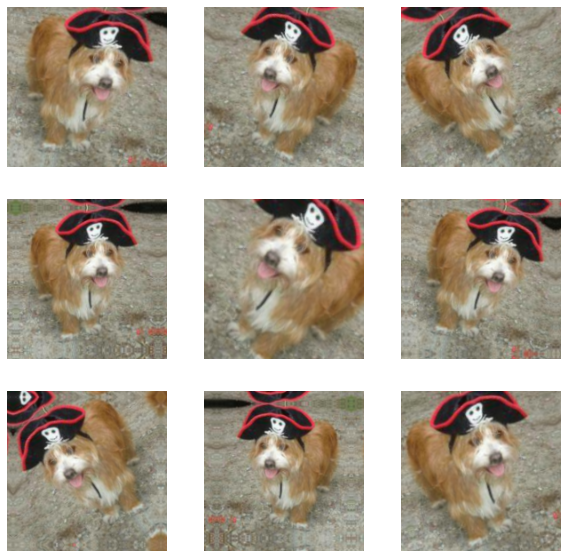

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Aprovechando una Convnet preentrenada
### Feature extraction with a pretrained model
**Instantiating the VGG16 convolutional base** 

In [9]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

#### Feature Extraction sin data augmentation

In [11]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [12]:
train_features.shape

(2000, 5, 5, 512)

## Clasificador Densamente conectado

In [13]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-02-14 16:52:43.076 tensorflow-2-6-gpu--ml-g4dn-xlarge-0201d392adbb6351f674da89d00b:3230 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-14 16:52:43.102 tensorflow-2-6-gpu--ml-g4dn-xlarge-0201d392adbb6351f674da89d00b:3230 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
63/63 [==============================] - 1s 7ms/step - loss: 14.7198 - accuracy: 0.9235 - val_loss: 5.7209 - val_accuracy: 0.9680
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 3.0363 - accuracy: 0.9780 - val_loss: 5.9079 - val_accuracy: 0.9640
Epoch 3/20
63/63 [=======

### Resultados

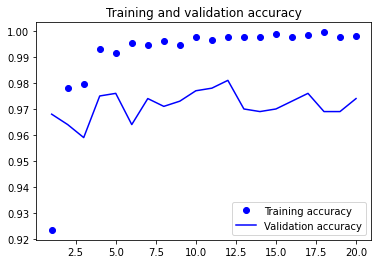

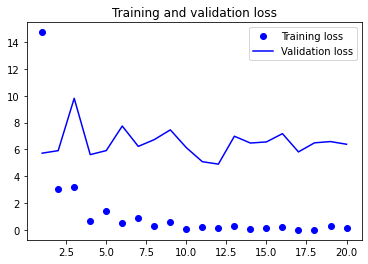

In [14]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation
**Instantiating and freeze the VGG16 convolutional base**

In [16]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [17]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


**Adding data augmentation and a densely-connected classifier to the frozen convolutional base**

In [18]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3277

# Ajustando el modelo 3.0

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 10s 136ms/step - loss: 21.4485 - accuracy: 0.8950 - val_loss: 2.6544 - val_accuracy: 0.9700
Epoch 2/50
63/63 [==============================] - 8s 131ms/step - loss: 8.5499 - accuracy: 0.9410 - val_loss: 7.8998 - val_accuracy: 0.9580
Epoch 3/50
63/63 [==============================] - 8s 130ms/step - loss: 7.0991 - accuracy: 0.9495 - val_loss: 4.2591 - val_accuracy: 0.9690
Epoch 4/50
63/63 [==============================] - 8s 131ms/step - loss: 5.8723 - accuracy: 0.9570 - val_loss: 4.5287 - val_accuracy: 0.9720
Epoch 5/50
63/63 [==============================] - 8s 131ms/step - loss: 4.1805 - accuracy: 0.9665 - val_loss: 5.1283 - val_accuracy: 0.9710
Epoch 6/50
63/63 [==============================] - 8s 132ms/step - loss: 3.5961 - accuracy: 0.9720 - val_loss: 4.6073 - val_accuracy: 0.9730
Epoch 7/50
63/63 [==============================] - 8s 132ms/step - loss: 3.6229 - accuracy: 0.9715 - val_loss: 2.6611 - val_accuracy: 0.9760
Epoc

# Loss y accuracy en training

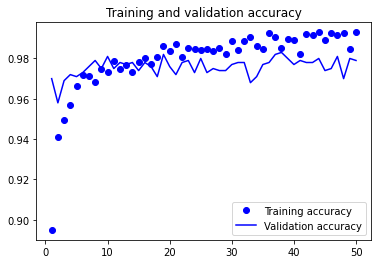

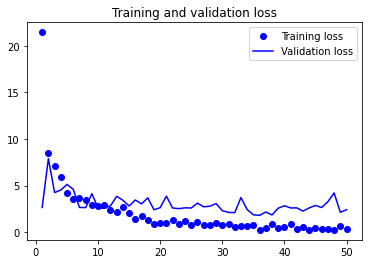

In [21]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Evauacion en el test

In [22]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 6s 84ms/step - loss: 2.4441 - accuracy: 0.9785
Test accuracy: 0.979


In [23]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Congelando las capas hasta las 4 últimas

In [24]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [25]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 175ms/step - loss: 0.9111 - accuracy: 0.9890 - val_loss: 2.2735 - val_accuracy: 0.9820
Epoch 2/30
63/63 [==============================] - 9s 146ms/step - loss: 0.6902 - accuracy: 0.9860 - val_loss: 1.9590 - val_accuracy: 0.9800
Epoch 3/30
63/63 [==============================] - 9s 147ms/step - loss: 0.4100 - accuracy: 0.9940 - val_loss: 1.8610 - val_accuracy: 0.9810
Epoch 4/30
63/63 [==============================] - 9s 145ms/step - loss: 0.5681 - accuracy: 0.9880 - val_loss: 1.8287 - val_accuracy: 0.9850
Epoch 5/30
63/63 [==============================] - 9s 145ms/step - loss: 0.3169 - accuracy: 0.9945 - val_loss: 2.5217 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 9s 144ms/step - loss: 0.2893 - accuracy: 0.9945 - val_loss: 2.1747 - val_accuracy: 0.9830
Epoch 7/30
63/63 [==============================] - 9s 145ms/step - loss: 0.0995 - accuracy: 0.9960 - val_loss: 2.3364 - val_accuracy: 0.9810
Epoch

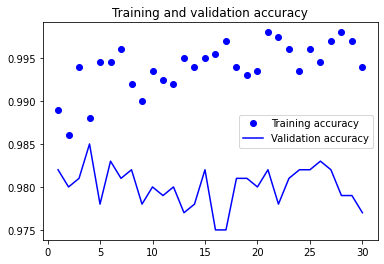

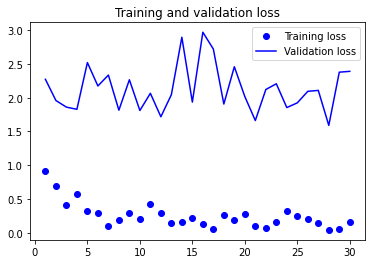

63/63 [==============================] - 6s 85ms/step - loss: 2.3409 - accuracy: 0.9750
Test accuracy: 0.975


In [26]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")